# Steps to build a pedigree and inject it in the simulation of the coalescence process of n genealogies

1. First install a couple of modules in case they are not installed in your computer or working environment:

In [ ]:
!python3 -m pip install networkx
!python3 -m pip install pandas
!python3 -m pip install matplotlib
!python3 -m pip install msprime
!python3 -m pip install tskit

2. Import all required modules

In [1]:
import io
import tskit
import msprime
from IPython.display import SVG, display
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import random
from itertools import chain
from typing import List, Dict, Tuple
import math
from multiprocessing import Pool
from itertools import chain


3. Create 2 functions for building the pedigree and for visualizing it:

    3.1 Function to create or parse the pedigree:

        Check that this function requires 3 parameters:

        a. N: Integer of the size of the population

        b. n: Integer of the size of the sample of interest at time zero.

        c. t: Integer of that indicates the time in the past we want to trace back all samples in the pedigree.

        d. partner_selection: Type of of selection of the partner parent (monogamy or polygamy).

        e. f_ind_in_big_families: Fraction of the current population that are the offsprings of big families.

        f. exp_big_family_size: Expected number of offspring of big families.

In [2]:

def build_random_pedigree(N,
                          n,
                          t,
                          partner_selection,
                          f_ind_in_big_families,
                          exp_big_family_size
                          ) -> Dict:

    times = list(range(round(2 * np.log2(N))))
    
    Pop_labels = list(range(N))
    Sample_labels = list(range(n))
    times = list(range(0, t))
    
    # Expected number of individuals in big families
    n_ind_bigfamilies = int(N * f_ind_in_big_families)
    
    # Expected number of unique parent pairs for big families
    if f_ind_in_big_families > 0 and exp_big_family_size > 0:
        n_parentpairs_for_big_families = round(n_ind_bigfamilies / exp_big_family_size)
    
    pedigree_table = pd.DataFrame()
    
    for time in times:
        # Define labels of individuals and parents in time t
        time_t_ind_labels = [x + time * N for x in Pop_labels]
        time_t_parent_labels = [x + (time + 1) * N for x in Pop_labels]
        
        if f_ind_in_big_families > 0 and exp_big_family_size > 0:
            # Select individuals that belong to bigfamilies and regular families
            time_t_bigfamily_members = np.random.choice(time_t_ind_labels, n_ind_bigfamilies, replace=False)
            time_t_normalfamily_members = [x for x in time_t_ind_labels if x not in time_t_bigfamily_members]
            
            # Define the parent pairs for the big families
            big_family_parent_pairs = []
            big_family_parent_labels = time_t_parent_labels.copy()
            
            for i in range(n_parentpairs_for_big_families):
                pair = np.random.choice(big_family_parent_labels, 2, replace=False)
                big_family_parent_pairs.append(pair)
                big_family_parent_labels = [x for x in big_family_parent_labels if x not in pair]
            
            normal_family_parent_labels = big_family_parent_labels
            
            # Assign individuals to each parent in big families
            big_family_records = []
            for ind in time_t_bigfamily_members:
                parent_pair = big_family_parent_pairs[np.random.randint(len(big_family_parent_pairs))]
                big_family_records.append({
                    'id': ind,
                    'parent0': parent_pair[0],
                    'parent1': parent_pair[1],
                    'time': time,
                    'is_sample': 1 if time == 0 else 0
                })
            big_family_pedigree_df = pd.DataFrame(big_family_records)
        else:
            time_t_normalfamily_members = time_t_ind_labels
            normal_family_parent_labels = time_t_parent_labels
        
        # Define regular parent pairs for monogamous or polygamous populations
        normal_family_records = []
        if partner_selection.lower() == 'monogamy':
            monogamous_normal_family_parent_pairs = []
            number_of_normal_pairs = len(normal_family_parent_labels) // 2
            
            available_parents = normal_family_parent_labels.copy()
            for _ in range(number_of_normal_pairs):
                pair = np.random.choice(available_parents, 2, replace=False)
                monogamous_normal_family_parent_pairs.append(pair)
                available_parents = [x for x in available_parents if x not in pair]
            
            for ind in time_t_normalfamily_members:
                parent_pair = monogamous_normal_family_parent_pairs[
                    np.random.randint(len(monogamous_normal_family_parent_pairs))]
                normal_family_records.append({
                    'id': ind,
                    'parent0': parent_pair[0],
                    'parent1': parent_pair[1],
                    'time': time,
                    'is_sample': 1 if time == 0 else 0
                })
        else:  # polygamy
            for ind in time_t_normalfamily_members:
                parent_pair = np.random.choice(time_t_parent_labels, 2, replace=False)
                normal_family_records.append({
                    'id': ind,
                    'parent0': parent_pair[0],
                    'parent1': parent_pair[1],
                    'time': time,
                    'is_sample': 1 if time == 0 else 0
                })
        
        normal_family_pedigree_df = pd.DataFrame(normal_family_records)
        
        if f_ind_in_big_families > 0 and exp_big_family_size > 0:
            pop_pedigree_table = pd.concat([normal_family_pedigree_df, big_family_pedigree_df])
        else:
            pop_pedigree_table = normal_family_pedigree_df
        
        pop_pedigree_table = pop_pedigree_table.sort_values('id')
        
        if time == 0:
            sample_pedigree_table = pop_pedigree_table.sample(n=n)
        else:
            sample_pedigree_table = pop_pedigree_table[
                pop_pedigree_table['id'].isin(samples_for_next_generation)]
        
        if time == times[-1]:
            sample_pedigree_table = pd.DataFrame({
                'id': samples_for_next_generation,
                'parent0': '.',
                'parent1': '.',
                'time': time + 1,
                'is_sample': 0
            })
        
        samples_for_next_generation = pd.concat([
            sample_pedigree_table['parent0'],
            sample_pedigree_table['parent1']
        ]).unique()
        
        sample_pedigree_table = sample_pedigree_table.sort_values('id')
        pedigree_table = pd.concat([pedigree_table, sample_pedigree_table])
    
    pedigree_table_string = "# id parent0 parent1 time is_sample\n"
    pedigree_table_string += pedigree_table.to_csv(
        sep='\t', index=False, header=False)
    
    return {
        'pedigree_table_string': pedigree_table_string,
        'pedigree_table': pedigree_table
    }

3.2 Function to draw the pedigree:

In [3]:

def draw_pedigree(ped_ts):

    G = nx.DiGraph()
    for ind in ped_ts.individuals():
        time = ped_ts.node(ind.nodes[0]).time
        pop = ped_ts.node(ind.nodes[0]).population
        G.add_node(ind.id, time=time, population=pop)
        for p in ind.parents:
            if p != tskit.NULL:
                G.add_edge(ind.id, p)
    pos = nx.multipartite_layout(G, subset_key="time", align="horizontal")
    colours = plt.rcParams['axes.prop_cycle'].by_key()['color']
    node_colours = [colours[node_attr["population"]] for node_attr in G.nodes.values()]
    nx.draw_networkx(G, pos, with_labels=True, node_color=node_colours)
    plt.show()

4. Function to summarize IBD information.

In [4]:
def summarize_pairwise_ibd(ts, N, seq_len):
    #get ibd information for sampled pairs
    segments = ts.ibd_segments(store_segments=True)

    #initialize list of segment lengths
    ibd_lengths = []
    ibd_times = []

    #add segment lengths to list
    for pair in list(segments.keys()):
        ibd_lengths.append(list(segments[pair].right-segments[pair].left))
        ibd_times.append(list(segments[pair].node))
    
    #flatten and convert to integer type
    ibd_lengths = list(chain(*ibd_lengths))
    ibd_times = list(chain(*ibd_times))
    ibd_times = [math.ceil(ibd_time/N) for ibd_time in ibd_times]
    
    ibd_segments = pd.DataFrame({
        'ibd_lengths': ibd_lengths,
        'ibd_times': ibd_times
        } 
    )
    
    ibd_min_times = []
    ibd_max_times = []
    ibd_frac = []
    ibd_nsegments = []

    for pair, segment_list in segments.items():
        ibd_min_times.append(min([segment.node for segment in list(segment_list)]))
        ibd_max_times.append(max([segment.node for segment in list(segment_list)]))
        ibd_frac.append(sum([segment.right - segment.left for segment in list(segment_list)])/seq_len)
        ibd_nsegments.append(len([segment.node for segment in list(segment_list)]))
    
    #flatten and convert to integer type

    pairwise_ibd = pd.DataFrame({
        'ibd_frac': ibd_frac,
        'ibd_min_times': [math.ceil(ibd_min_time/N) for ibd_min_time in ibd_min_times],
        'ibd_max_times': [math.ceil(ibd_max_time/N) for ibd_max_time in ibd_max_times],
        'ibd_nsegments': ibd_nsegments
        } 
    )
    
    return{
        'ibd_segments': ibd_segments,
        'pairwise_ibd': pairwise_ibd
    }


In [5]:


def process_segment_pair(pair_data):
    pair, segment_list = pair_data
    lengths = list(segment_list.right - segment_list.left)
    times = list(segment_list.node)
    min_time = min([segment.node for segment in list(segment_list)])
    max_time = max([segment.node for segment in list(segment_list)])
    frac = sum([segment.right - segment.left for segment in list(segment_list)])/seq_len
    nsegments = len([segment.node for segment in list(segment_list)])
    return lengths, times, min_time, max_time, frac, nsegments

def parallel_process_segments(segments):
    with Pool() as pool:
        results = pool.map(process_segment_pair, segments.items())
    
    # Unpack results
    lengths, times, min_times, max_times, fracs, nsegments = zip(*results)
    
    # Flatten length and time lists
    ibd_lengths = list(chain(*lengths))
    ibd_times = list(chain(*times))
    ibd_times = [math.ceil(ibd_time/N) for ibd_time in ibd_times]
    
    # Create DataFrames
    ibd_segments = pd.DataFrame({
        'ibd_lengths': ibd_lengths,
        'ibd_times': ibd_times
    })
    
    pairwise_ibd = pd.DataFrame({
        'ibd_frac': fracs,
        'ibd_min_times': [math.ceil(min_time/N) for min_time in min_times],
        'ibd_max_times': [math.ceil(max_time/N) for max_time in max_times],
        'ibd_nsegments': nsegments
    })
    
    return ibd_segments, pairwise_ibd

# Usage
#segments = ts.ibd_segments(store_segments=True)
#ibd_segments, pairwise_ibd = parallel_process_segments(segments)

Lets run an example on how to use this two functions:

    a. First create the pedigree:
    
        For that we need to define the four inputs. To make a short demo let's define them as follow: 

In [6]:

N = 10
n = round(1 * N)
t = round(2 * np.log2(N))
partner_selection = 'monogamy'
f_ind_in_big_families = 0.3
exp_big_family_size = 3

This mean that we are going to follow the full population of 10 individuals for 7 generations and in each generation 4 individuals are siblings from the same father and mother.

Other assumptions of the model are:

    * The population is diploid monoecious (so no sex is defined).

    * All samples in t_0 will have a value of 1 in the flag (column) is_sample, which mean they are going to be included in the simulation. For a future Implementation a parameter to randomly or manually define the samples to be included will be added.

    * Individuals that don't belong to the big family may share the same parents as a function of the size of the population. If N is big and n is small respect to N, this won't happen.

    * Individuals ar allowed to have multiple partners. If N is big and n is small respect to N, this won't happen or will be rare.

Notice that the output of this function is a table stored as a string and that can be visualized using print().


In [7]:

pedigree_string = build_random_pedigree(N = N, 
                                        n = n, 
                                        t = 3, 
                                        partner_selection = partner_selection,
                                        f_ind_in_big_families = f_ind_in_big_families,
                                        exp_big_family_size = exp_big_family_size
                                        )
pedigree_string['pedigree_table_string']
#print(pedigree_string['pedigree_table'])

#pd.set_option('display.max_rows', None)
pedigree_string['pedigree_table']

,id,parent0,parent1,time,is_sample
0,0,10,12,0,1
0,1,11,15,0,1
1,2,11,15,0,1
1,3,10,12,0,1
2,4,11,15,0,1
3,5,14,18,0,1
4,6,11,15,0,1
2,7,10,12,0,1
5,8,14,18,0,1
6,9,19,16,0,1


b. Parse the pedigree into msprime:

In [8]:
pedigree_table = msprime.parse_pedigree(io.StringIO(pedigree_string['pedigree_table_string']), sequence_length=1000)


c. Draw the pedigree:

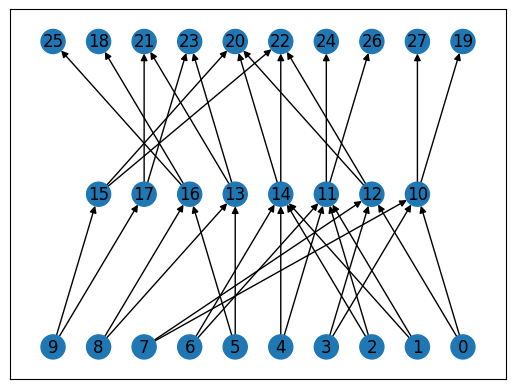

In [9]:
draw_pedigree(pedigree_table.tree_sequence())

d. Now we can use this pedigree to create our simulation:

   Notice that the .sim_ancestry method allows the following arguments:

    * samples: Any | None = None,*,

    * demography: Any | None = None,

    * sequence_length: Any | None = None,

    * discrete_genome: Any | None = None,

    * recombination_rate: Any | None = None,

    * gene_conversion_rate: Any | None = None,

    * gene_conversion_tract_length: Any | None = None,

    * population_size: Any | None = None,

    * ploidy: Any | None = None,

    * model: Any | None = None,

    * initial_state: Any | None = None,

    * start_time: Any | None = None,

    * end_time: Any | None = None,

    * record_migrations: Any | None = None,

    * record_full_arg: Any | None = None,

    * additional_nodes: Any | None = None,

    * coalescing_segments_only: Any | None = None,

    * num_labels: Any | None = None,

    * random_seed: Any | None = None,

    * num_replicates: Any | None = None,

    * replicate_index: Any | None = None,

    * record_provenance: Any | None = None

As the number of samples and the length of the sequence have been defined in the previous step, these two argument are already included in the argument initial_state

In [10]:
ts_w_ped = msprime.sim_ancestry(
    initial_state=pedigree_table,
    model='fixed_pedigree',
    recombination_rate=0.0001,
    random_seed=45,
 #   additional_nodes=(
#         msprime.NodeType.RECOMBINANT |
#         msprime.NodeType.PASS_THROUGH | 
#         msprime.NodeType.COMMON_ANCESTOR
#         ),
    coalescing_segments_only=False
)

In [11]:
ts_w_ped

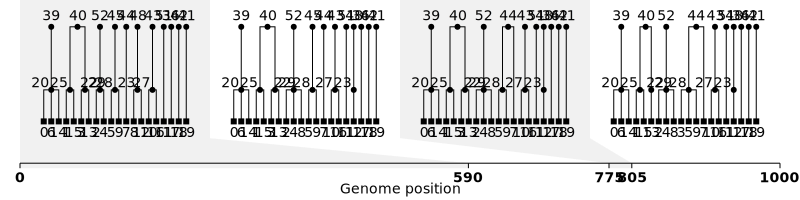

In [12]:
SVG(ts_w_ped.draw_svg())

# Tested models
## Parameters for all models

In [13]:
chrom_length = [1e6]*10
chrom_length

[1000000.0,
 1000000.0,
 1000000.0,
 1000000.0,
 1000000.0,
 1000000.0,
 1000000.0,
 1000000.0,
 1000000.0,
 1000000.0]

In [14]:
N = 10000
n = round(0.1 * N)
t = int(round(2 * np.log2(N)))
seq_len = 1000000
rho = 0.5e-6
mut = 1e-9

## Model with Pedigree without big families and only 1 chromosome

In [15]:
partner_selection = 'monogamy'
f_ind_in_big_families = 0
exp_big_family_size = 0

In [16]:
seq_len

1000000

In [17]:
pedigree_string = build_random_pedigree(N = N, 
                                        n = n, 
                                        t = t, 
                                        partner_selection = partner_selection,
                                        f_ind_in_big_families = f_ind_in_big_families,
                                        exp_big_family_size = exp_big_family_size
                                        )

In [18]:
pedigree_table = msprime.parse_pedigree(io.StringIO(pedigree_string['pedigree_table_string']), sequence_length=seq_len)

ts_w_ped_1ch = msprime.sim_ancestry(
    initial_state=pedigree_table,
    model='fixed_pedigree',
    recombination_rate=0.5e-6,
    random_seed=45,
    coalescing_segments_only=False
)

In [19]:
mutated_ts_w_ped_1ch = msprime.sim_mutations(ts_w_ped_1ch, rate = mut, random_seed = 500)

In [20]:
pairwise_ibd_w_ped_1ch = summarize_pairwise_ibd(ts = mutated_ts_w_ped_1ch, N = N, seq_len = seq_len)

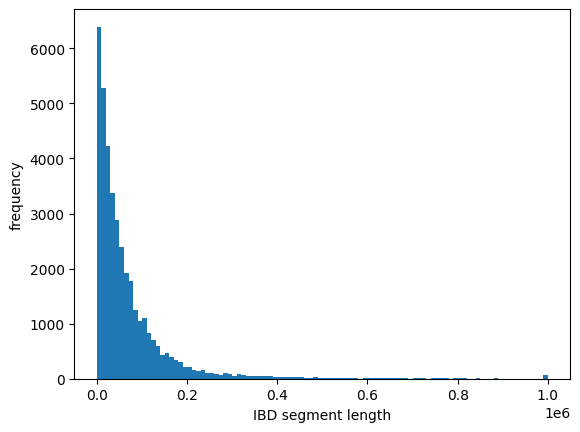

In [21]:
#plot
histogram = plt.hist(pairwise_ibd_w_ped_1ch['ibd_segments']['ibd_lengths'], 100)
plt.xlabel('IBD segment length')
plt.ylabel('frequency')
plt.show()

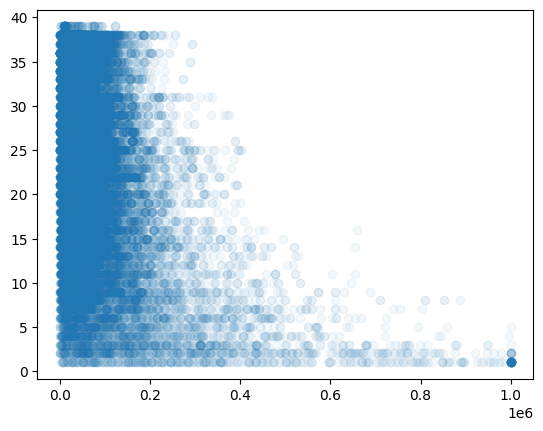

In [22]:
plt.scatter(pairwise_ibd_w_ped_1ch['ibd_segments']['ibd_lengths'], pairwise_ibd_w_ped_1ch['ibd_segments']['ibd_times'], alpha = 0.05)
plt.show()

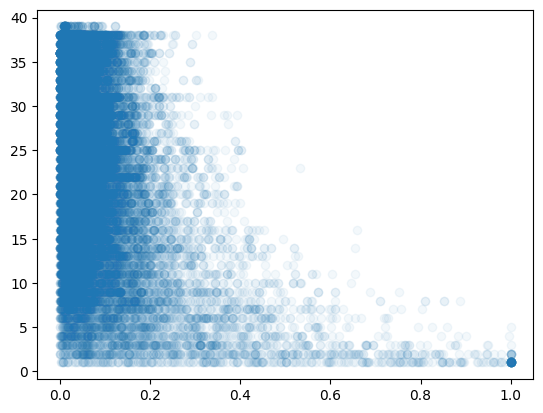

In [23]:
plt.scatter(pairwise_ibd_w_ped_1ch['pairwise_ibd']['ibd_frac'], pairwise_ibd_w_ped_1ch['pairwise_ibd']['ibd_min_times'], alpha = 0.05)
plt.show()

## Model with Pedigree without big families

### Parameters

In [16]:
partner_selection = 'monogamy'
f_ind_in_big_families = 0
exp_big_family_size = 0

In [24]:
ts_w_ped_10ch = []

#pedigree = msprime.parse_pedigree(io.StringIO(ped_txt), sequence_length=1)
pedigree_table = msprime.parse_pedigree(io.StringIO(pedigree_string['pedigree_table_string']), sequence_length=1)
for i, (L) in enumerate(chrom_length):
    pedigree_table.sequence_length = L
    ped_ts = msprime.sim_ancestry(
        initial_state=pedigree_table, model="fixed_pedigree",
        recombination_rate= rho, random_seed=i+1)
    
    ped_ts_chrom = msprime.sim_ancestry(
            initial_state=ped_ts, population_size = N,
            recombination_rate = rho, model="dtwf", random_seed=i+100)
    
    mutated_ped_ts_chrom = msprime.sim_mutations(ped_ts_chrom, rate = mut, random_seed = i+500)
    
    ts_w_ped_10ch.append(
        mutated_ped_ts_chrom)
    print(i)

0
1
2
3
4
5
6
7
8
9


In [25]:
len(ts_w_ped_10ch)

10

Sampling pairs and plotting lenghts of IBD segments in pairs

In [26]:
ts_w_ped_10ch[0]

In [ ]:
ts_w_ped_ch0 = ts_w_ped_10ch[0]

In [ ]:
pairwise_ibd_w_ped0 = summarize_pairwise_ibd(ts = ts_w_ped_10ch[0], N = N, seq_len = seq_len)

TypeError: summarize_pairwise_ibd() missing 2 required positional arguments: 'N' and 'seq_len'

In [ ]:
pairwise_ibd_w_ped0['pairwise_ibd'].to_csv('pairwise_ibd_w_ped_ch0.csv', index=False)

In [ ]:

pairwise_ibd_w_ped1 = summarize_pairwise_ibd(ts = ts_w_ped_10ch[1])
pairwise_ibd_w_ped2 = summarize_pairwise_ibd(ts = ts_w_ped_10ch[2])
pairwise_ibd_w_ped3 = summarize_pairwise_ibd(ts = ts_w_ped_10ch[3])
pairwise_ibd_w_ped4 = summarize_pairwise_ibd(ts = ts_w_ped_10ch[4])
pairwise_ibd_w_ped5 = summarize_pairwise_ibd(ts = ts_w_ped_10ch[5])
pairwise_ibd_w_ped6 = summarize_pairwise_ibd(ts = ts_w_ped_10ch[6])
pairwise_ibd_w_ped7 = summarize_pairwise_ibd(ts = ts_w_ped_10ch[7])
pairwise_ibd_w_ped8 = summarize_pairwise_ibd(ts = ts_w_ped_10ch[8])
pairwise_ibd_w_ped9 = summarize_pairwise_ibd(ts = ts_w_ped_10ch[9])


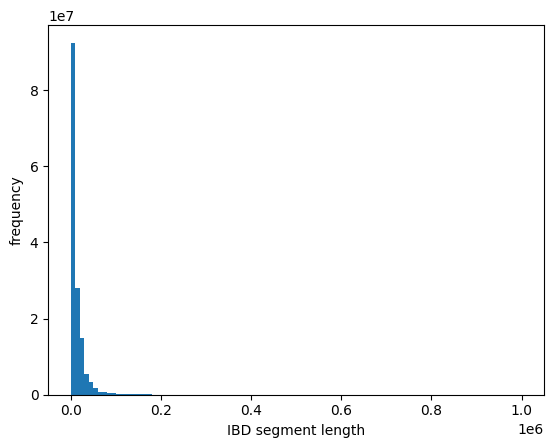

In [28]:
#plot
histogram = plt.hist(pairwise_ibd_w_ped['ibd_segments']['ibd_lengths'], 100)
plt.xlabel('IBD segment length')
plt.ylabel('frequency')
plt.show()

In [29]:
sum(pairwise_ibd_w_ped['pairwise_ibd']['ibd_nsegments'])/len(pairwise_ibd_w_ped['pairwise_ibd']['ibd_nsegments'])

75.09097048524262

In [1]:
rho

NameError: name 'rho' is not defined

In [ ]:
plt.scatter(pairwise_ibd_w_ped['ibd_segments']['ibd_lengths'], pairwise_ibd_w_ped['ibd_segments']['ibd_times'], alpha = 0.05)
plt.show()

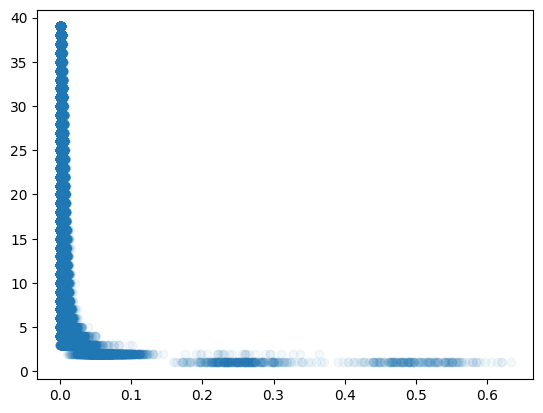

In [26]:
plt.scatter(pairwise_ibd_w_ped['pairwise_ibd']['ibd_frac'], pairwise_ibd_w_ped['pairwise_ibd']['ibd_min_times'], alpha = 0.05)
plt.show()

## Model with Pedigree with big families
### Parameters

In [27]:
partner_selection_w_bigf = 'monogamy'
f_ind_in_big_families_w_bigf = 0.5
exp_big_family_size_w_bigf = 1000

In [28]:
pedigree_string_w_bigf = build_random_pedigree(N = N, 
                                        n = n, 
                                        t = t, 
                                        partner_selection = partner_selection_w_bigf,
                                        f_ind_in_big_families = f_ind_in_big_families_w_bigf,
                                        exp_big_family_size = exp_big_family_size_w_bigf
                                        )

In [29]:
pedigree_table_w_bigf = msprime.parse_pedigree(io.StringIO(pedigree_string_w_bigf['pedigree_table_string']), sequence_length=seq_len)

ts_w_ped_bigf = msprime.sim_ancestry(
    initial_state=pedigree_table_w_bigf,
    model='fixed_pedigree',
    recombination_rate=rho,
    random_seed=45,
    coalescing_segments_only=False
)

mutated_ts_w_ped_bigf = msprime.sim_mutations(ts_w_ped_bigf, rate = mut, random_seed = 54321)

In [30]:
pairwise_ibd_w_ped_bigf = summarize_pairwise_ibd(ts = mutated_ts_w_ped_bigf)

KeyboardInterrupt: 

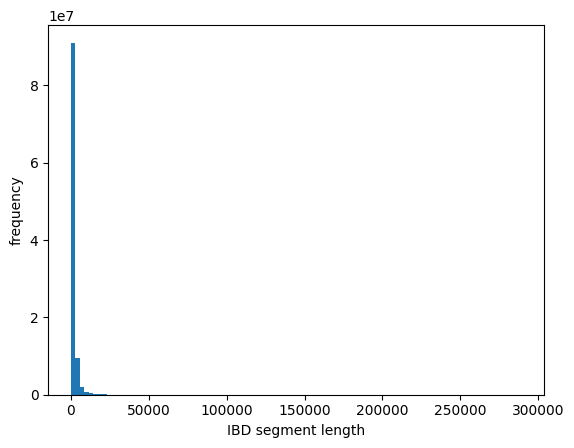

In [242]:
#plot
histogram = plt.hist(pairwise_ibd_w_ped_bigf['ibd_segments']['ibd_lengths'], 100)
plt.xlabel('IBD segment length')
plt.ylabel('frequency')
plt.show()

In [243]:
sum(pairwise_ibd_w_ped_bigf['pairwise_ibd']['ibd_nsegments'])/len(pairwise_ibd_w_ped_bigf['pairwise_ibd']['ibd_nsegments'])

52.11717058529265

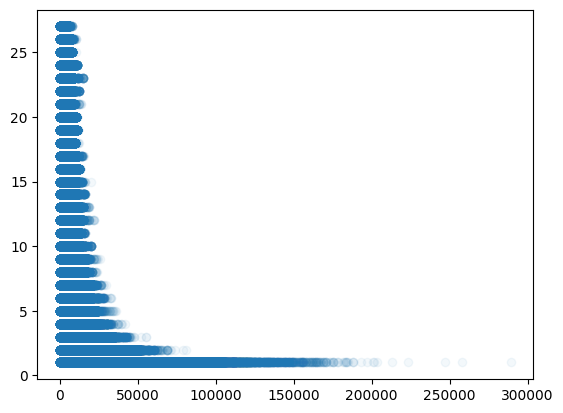

In [244]:
plt.scatter(pairwise_ibd_w_ped_bigf['ibd_segments']['ibd_lengths'], pairwise_ibd_w_ped_bigf['ibd_segments']['ibd_times'], alpha = 0.05)
plt.show()

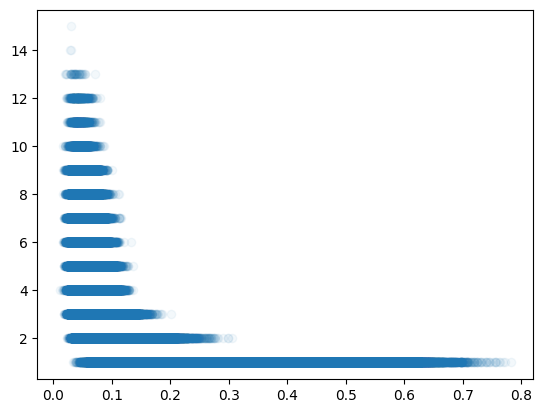

In [245]:
plt.scatter(pairwise_ibd_w_ped_bigf['pairwise_ibd']['ibd_frac'], 
            pairwise_ibd_w_ped_bigf['pairwise_ibd']['ibd_min_times'], 
            alpha = 0.05)
plt.show()

# Model without Pedigree

In [ ]:
N = 10000
n = round(0.01 * N)
seq_len = 1000
rho = 10e-4
mut = 10e-4

ts_wo_ped = msprime.sim_ancestry(
    samples = n,
    recombination_rate = rho,
    random_seed = 45,
    sequence_length = seq_len,
    population_size = N,
    coalescing_segments_only=False
)

In [26]:
mutated_ts_wo_ped = msprime.sim_mutations(ts_wo_ped, rate = mut, random_seed = 54321)

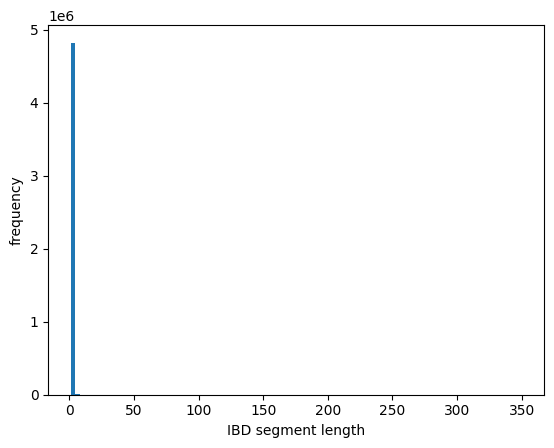

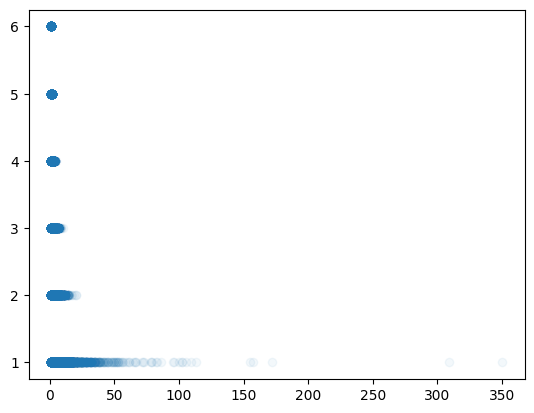

In [28]:


sample_size = 100
subset = random.sample(range(0,2*n-1), sample_size)

#get ibd information for sampled pairs
segments = mutated_ts_wo_ped.ibd_segments(within=subset, store_segments=True)

#initialize list of segment lengths
ibd_lengths = []
ibd_times = []
#add segment lengths to list
for pair in list(segments.keys()):
    ibd_lengths.append(list(segments[pair].right-segments[pair].left))
    ibd_times.append(list(segments[pair].node))


#flatten and convert to integer type
ibd_lengths = list(chain(*ibd_lengths))
ibd_lengths = np.array(ibd_lengths, dtype=int)

ibd_times = list(chain(*ibd_times))
ibd_times = [math.ceil(ibd_time/N) for ibd_time in ibd_times]
ibd_times = np.array(ibd_times, dtype=int)



#plot
histogram = plt.hist(ibd_lengths, 100)
plt.xlabel('IBD segment length')
plt.ylabel('frequency')
plt.show()

plt.scatter(ibd_lengths, ibd_times, alpha = 0.05)
plt.show()